# Time Series Analysis and Forecasts with Prophet using Rossmann Store Sales dataset



In [19]:
import warnings
warnings.filterwarnings("ignore")

# loading packages
# basic + dates 
import numpy as np
import pandas as pd
from pandas import datetime

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns # advanced vizs
%matplotlib inline

# statistics
from statsmodels.distributions.empirical_distribution import ECDF

# time series analysis
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# prophet by Facebook
from fbprophet import Prophet

# machine learning: XGB
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from xgboost.sklearn import XGBRegressor # wrapper

In [20]:
# importing train data to learn
train = pd.read_csv("C:/Users/MANOJ/Downloads/KaiBurr ML/time-series-prophet-master/train.csv", 
                    parse_dates = True, low_memory = False, index_col = 'Date')

# additional store data
store = pd.read_csv("C:/Users/MANOJ/Downloads/KaiBurr ML/time-series-prophet-master/store.csv", 
                    low_memory = False)
# time series as indexes
train.index

DatetimeIndex(['2015-07-31', '2015-07-31', '2015-07-31', '2015-07-31',
               '2015-07-31', '2015-07-31', '2015-07-31', '2015-07-31',
               '2015-07-31', '2015-07-31',
               ...
               '2013-01-01', '2013-01-01', '2013-01-01', '2013-01-01',
               '2013-01-01', '2013-01-01', '2013-01-01', '2013-01-01',
               '2013-01-01', '2013-01-01'],
              dtype='datetime64[ns]', name='Date', length=1017209, freq=None)

## Exploratory Data Analysis 

In [21]:
# first glance at the train set: head and tail
print("In total: ", train.shape)
train.head(5).append(train.tail(5))

In total:  (1017209, 8)


,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1
2015-07-31,2,5,6064,625,1,1,0,1
2015-07-31,3,5,8314,821,1,1,0,1
2015-07-31,4,5,13995,1498,1,1,0,1
2015-07-31,5,5,4822,559,1,1,0,1
2013-01-01,1111,2,0,0,0,0,a,1
2013-01-01,1112,2,0,0,0,0,a,1
2013-01-01,1113,2,0,0,0,0,a,1
2013-01-01,1114,2,0,0,0,0,a,1


Short description:
- Sales: the turnover for any given day (target variable).
- Customers: the number of customers on a given day.
- Open: an indicator for whether the store was open: 0 = closed, 1 = open.
- Promo: indicates whether a store is running a promo on that day.
- StateHoliday: indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. 
- SchoolHoliday: indicates if the (Store, Date) was affected by the closure of public schools.

In [22]:
# data extraction
train['Year'] = train.index.year
train['Month'] = train.index.month
train['Day'] = train.index.day
train['WeekOfYear'] = train.index.weekofyear

# adding new variable
train['SalePerCustomer'] = train['Sales']/train['Customers']
train['SalePerCustomer'].describe()

count    844340.000000
mean          9.493619
std           2.197494
min           0.000000
25%           7.895563
50%           9.250000
75%          10.899729
max          64.957854
Name: SalePerCustomer, dtype: float64

On average customers spend about 9.50$ per day. Though there are days with Sales equal to zero.

### ECDF: empirical cumulative distribution function

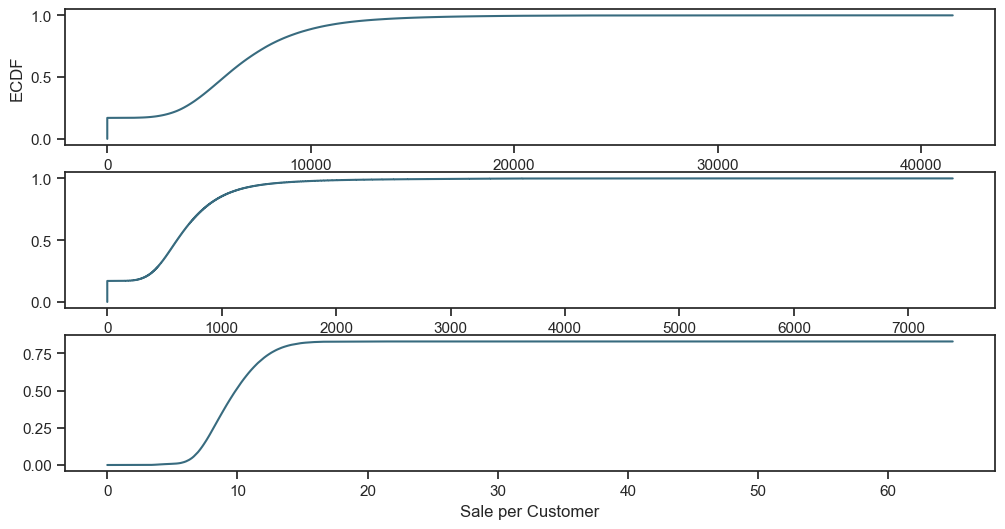

In [23]:
sns.set(style = "ticks")# to format into seaborn 
c = '#386B7F' # basic color for plots
plt.figure(figsize = (12, 6))

plt.subplot(311)
cdf = ECDF(train['Sales'])
plt.plot(cdf.x, cdf.y, label = "statmodels", color = c);
plt.xlabel('Sales'); plt.ylabel('ECDF');

# plot second ECDF  
plt.subplot(312)
cdf = ECDF(train['Customers'])
plt.plot(cdf.x, cdf.y, label = "statmodels", color = c);
plt.xlabel('Customers');

# plot second ECDF  
plt.subplot(313)
cdf = ECDF(train['SalePerCustomer'])
plt.plot(cdf.x, cdf.y, label = "statmodels", color = c);
plt.xlabel('Sale per Customer');

### Missing values 
#### Closed stores and zero sales stores

In [24]:
# closed stores
train[(train.Open == 0) & (train.Sales == 0)].head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear,SalePerCustomer
Date,,,,,,,,,,,,,
2015-07-31,292,5,0,0,0,1,0,1,2015,7,31,31,NaN
2015-07-31,876,5,0,0,0,1,0,1,2015,7,31,31,NaN
2015-07-30,292,4,0,0,0,1,0,1,2015,7,30,31,NaN
2015-07-30,876,4,0,0,0,1,0,1,2015,7,30,31,NaN
2015-07-29,292,3,0,0,0,1,0,1,2015,7,29,31,NaN


In [25]:
# opened stores with zero sales
zero_sales = train[(train.Open != 0) & (train.Sales == 0)]
print("In total: ", zero_sales.shape)
zero_sales.head(5)

In total:  (54, 13)


,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear,SalePerCustomer
Date,,,,,,,,,,,,,
2015-05-15,971,5,0,0,1,0,0,1,2015,5,15,20,NaN
2015-03-26,674,4,0,0,1,0,0,0,2015,3,26,13,NaN
2015-02-05,699,4,0,0,1,1,0,0,2015,2,5,6,NaN
2014-10-01,708,3,0,0,1,1,0,0,2014,10,1,40,NaN
2014-09-22,357,1,0,0,1,0,0,0,2014,9,22,39,NaN


In [26]:
print("Closed stores and days which didn't have any sales won't be counted into the forecasts.")
train = train[(train["Open"] != 0) & (train['Sales'] != 0)]

print("In total: ", train.shape)

Closed stores and days which didn't have any sales won't be counted into the forecasts.
In total:  (844338, 13)


In [27]:
# additional information about the stores
store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


- Store: a unique Id for each store
- StoreType: differentiates between 4 different store models: a, b, c, d
- Assortment: describes an assortment level: a = basic, b = extra, c = extended
- CompetitionDistance: distance in meters to the nearest competitor store
- CompetitionOpenSince[Month/Year]: gives the approximate year and month of the time the nearest competitor was opened
- Promo2: Promo2 is a continuing a promotion for some stores: 0 = store is not participating, 1 = store is participating
- Promo2Since[Year/Week]: describes the year and calendar week when the store started participating in Promo2
- PromoInterval: describes the consecutive intervals Promo2 is started, naming the months the promotion is started. 

In [28]:
# missing values?
store.isnull().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

In [29]:
# missing values in CompetitionDistance
store[pd.isnull(store.CompetitionDistance)]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
290,291,d,a,NaN,NaN,NaN,0,NaN,NaN,NaN
621,622,a,c,NaN,NaN,NaN,0,NaN,NaN,NaN
878,879,d,a,NaN,NaN,NaN,1,5.0,2013.0,"Feb,May,Aug,Nov"


In [30]:
# fill NaN with a median value (skewed distribuion)
store['CompetitionDistance'].fillna(store['CompetitionDistance'].median(), inplace = True)

In [31]:
# no promo = no information about the promo?
_ = store[pd.isnull(store.Promo2SinceWeek)]
_[_.Promo2 != 0].shape

(0, 10)

In [32]:
# replace NA's by 0
store.fillna(0, inplace = True)

In [33]:
print("Joining train set with an additional store information.")

# by specifying inner join we make sure that only those observations 
# that are present in both train and store sets are merged together
train_store = pd.merge(train, store, how = 'inner', on = 'Store')

print("In total: ", train_store.shape)
train_store.head()

Joining train set with an additional store information.
In total:  (844338, 22)


,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,...,SalePerCustomer,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,5263,555,1,1,0,1,2015,7,...,9.482883,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
1,1,4,5020,546,1,1,0,1,2015,7,...,9.194139,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
2,1,3,4782,523,1,1,0,1,2015,7,...,9.143403,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
3,1,2,5011,560,1,1,0,1,2015,7,...,8.948214,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
4,1,1,6102,612,1,1,0,1,2015,7,...,9.970588,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0


### Store types

In [34]:
train_store.groupby('StoreType')['Sales'].describe()

,count,mean,std,min,25%,50%,75%,max
StoreType,,,,,,,,
a,457042.0,6925.697986,3277.351589,46.0,4695.25,6285.0,8406.00,41551.0
b,15560.0,10233.380141,5155.729868,1252.0,6345.75,9130.0,13184.25,38722.0
c,112968.0,6933.126425,2896.958579,133.0,4916.00,6408.0,8349.25,31448.0
d,258768.0,6822.300064,2556.401455,538.0,5050.00,6395.0,8123.25,38037.0


In [35]:
train_store.groupby('StoreType')['Customers', 'Sales'].sum()

,Customers,Sales
StoreType,,
a,363541431,3165334859
b,31465616,159231395
c,92129705,783221426
d,156904995,1765392943


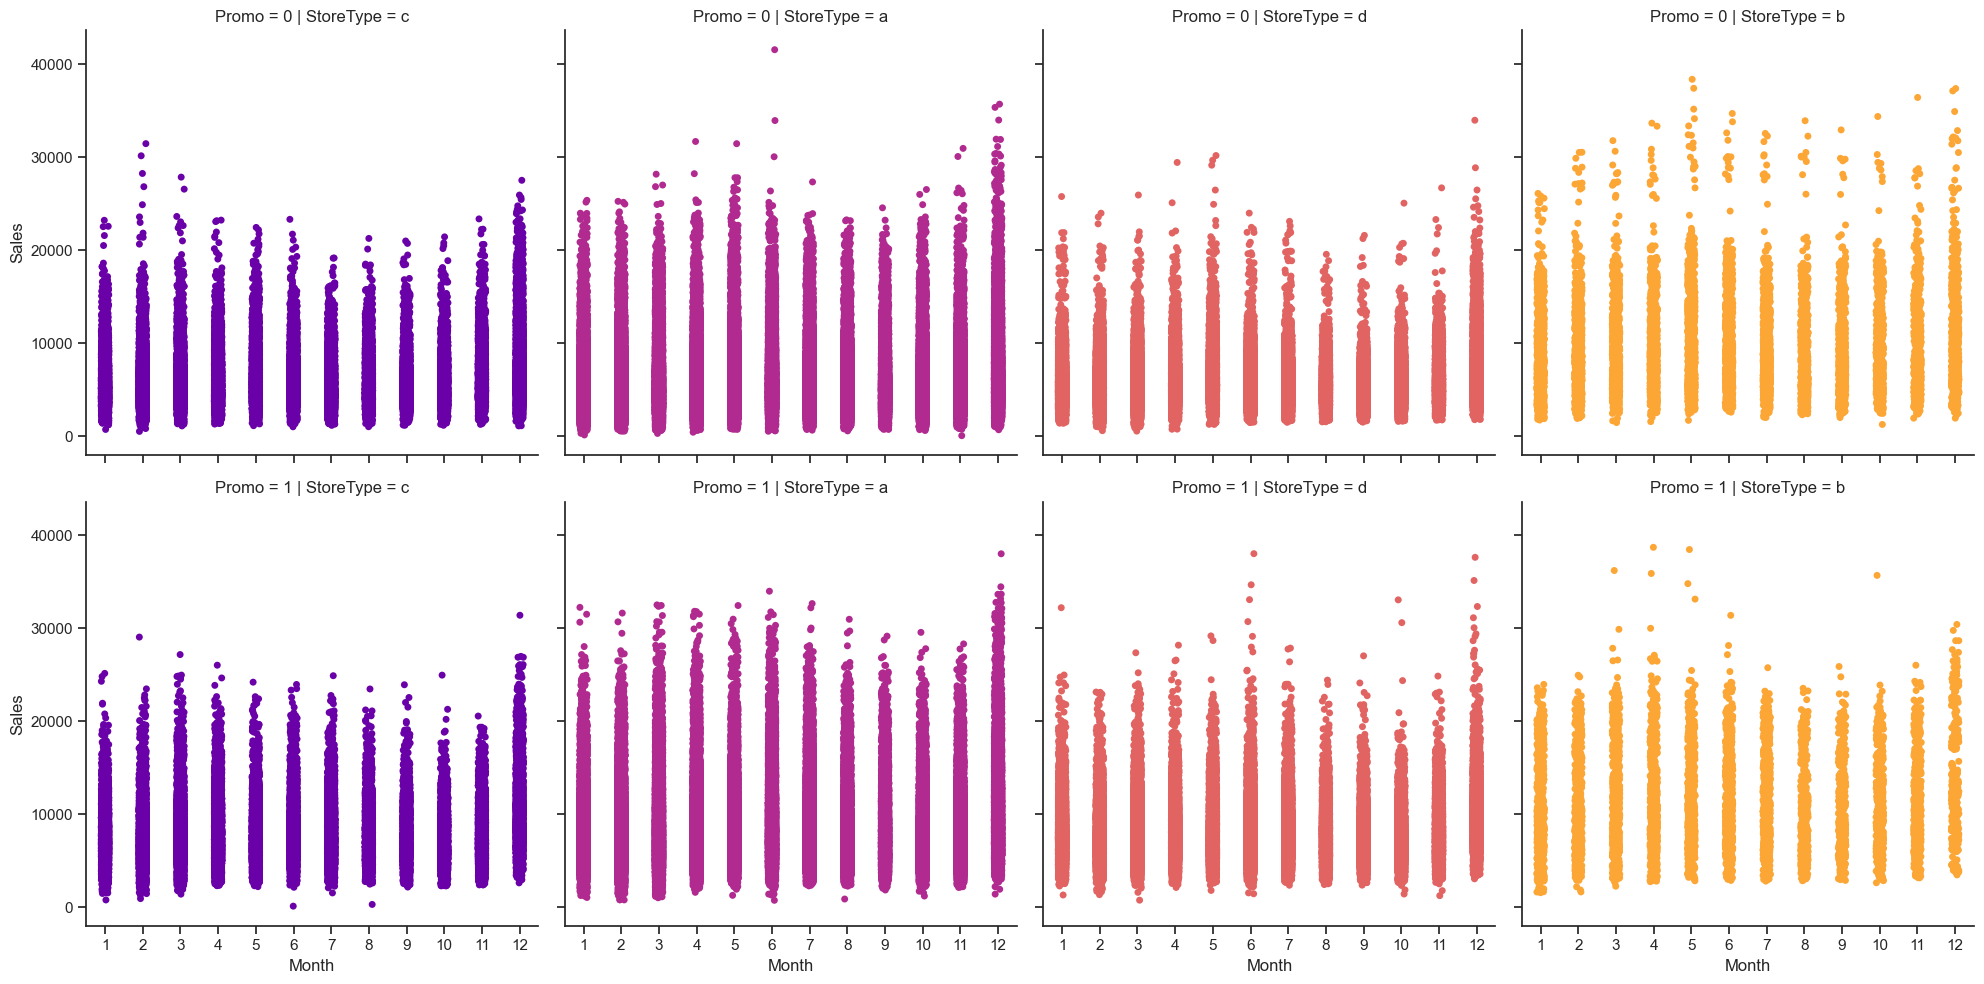

In [37]:
# sales trends
sns.catplot(data = train_store, x = 'Month', y = "Sales", 
               col = 'StoreType', # per store type in cols
               palette = 'plasma',
               hue = 'StoreType',
               row = 'Promo', # per promo in the store in rows
               color = c) 

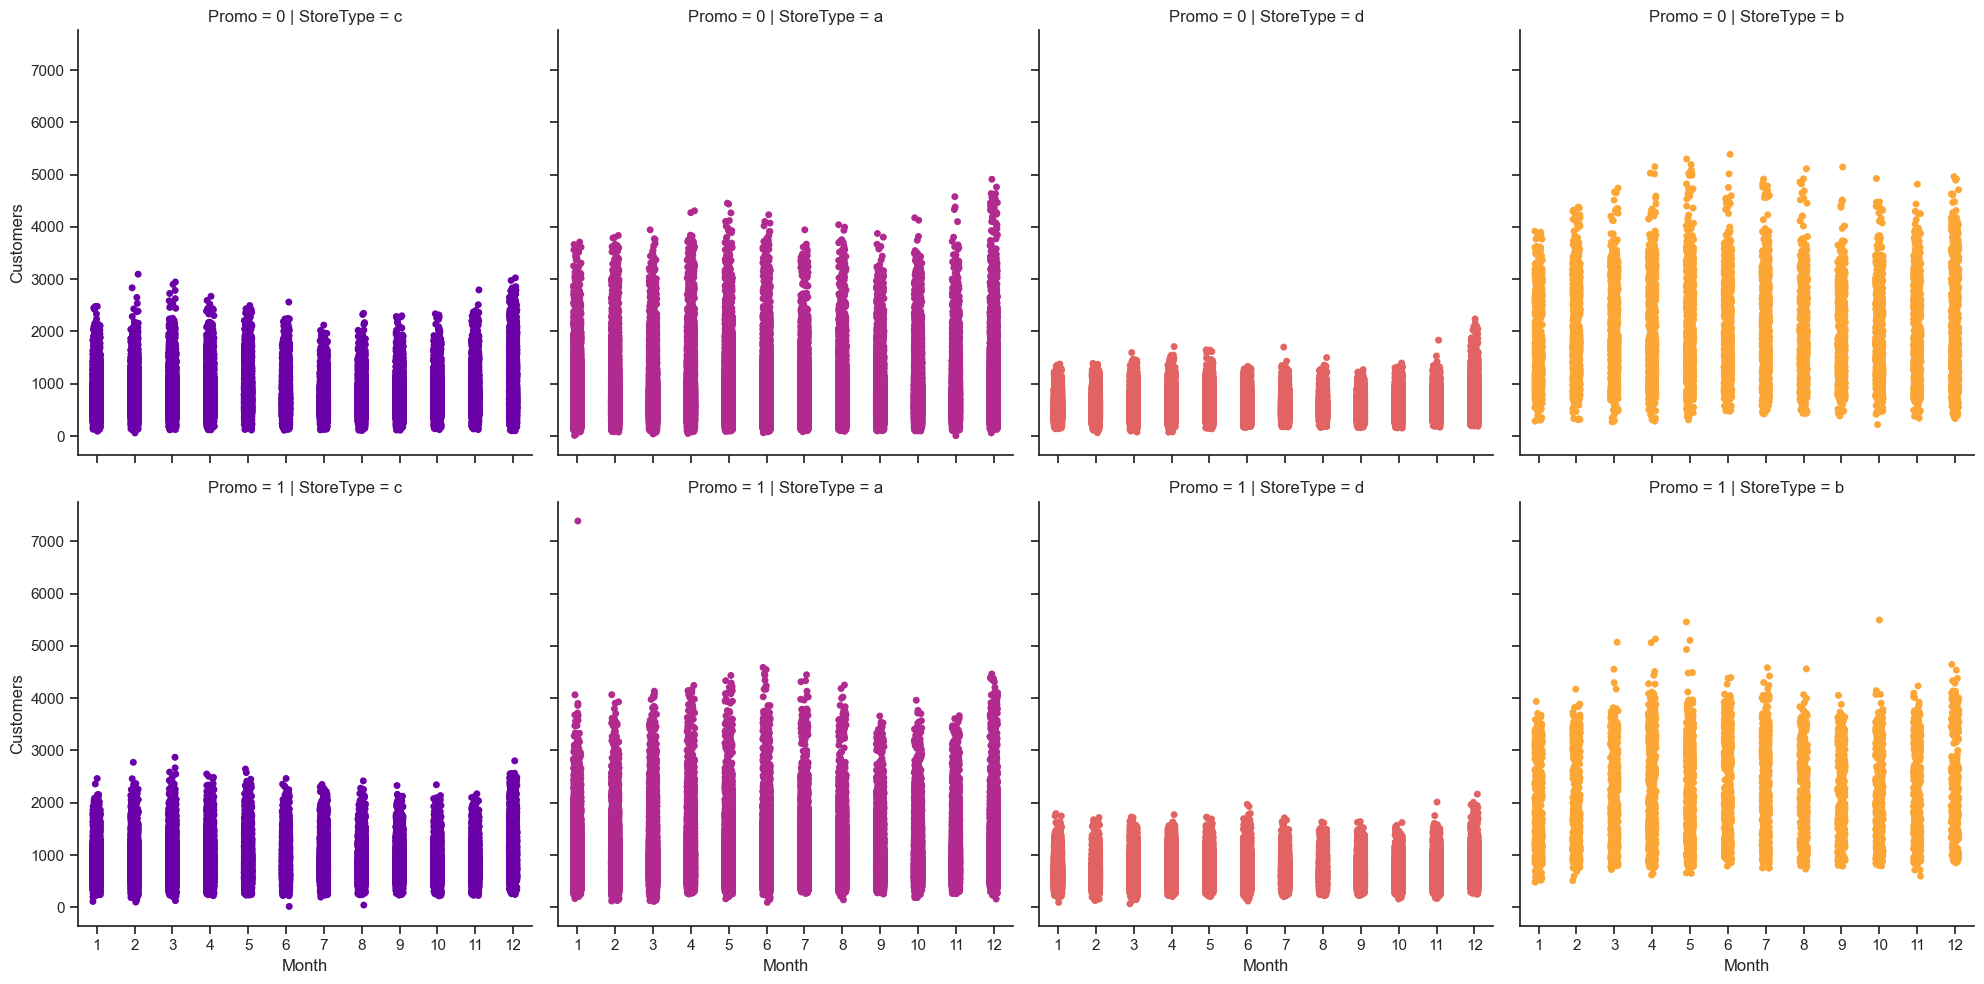

In [38]:
# sales trends
sns.catplot(data = train_store, x = 'Month', y = "Customers", 
               col = 'StoreType', # per store type in cols
               palette = 'plasma',
               hue = 'StoreType',
               row = 'Promo', # per promo in the store in rows
               color = c) 

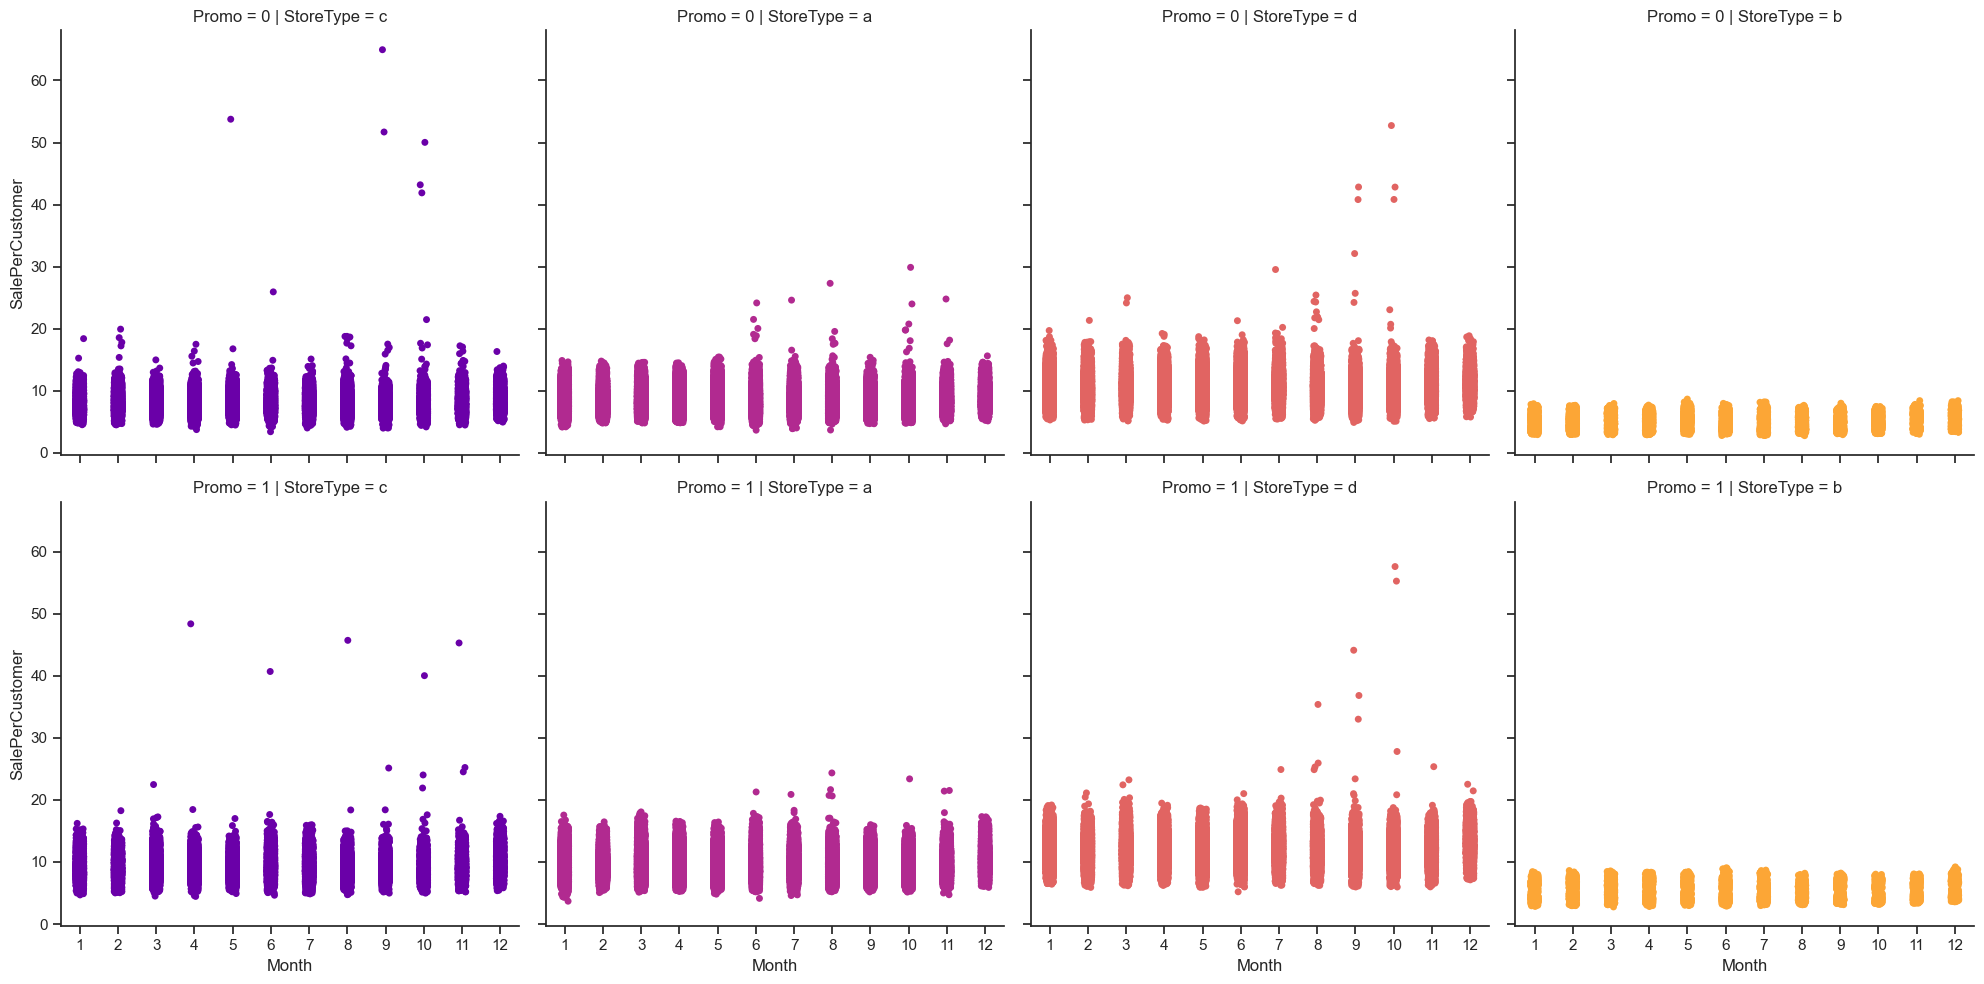

In [39]:
# sale per customer trends
sns.catplot(data = train_store, x = 'Month', y = "SalePerCustomer", 
               col = 'StoreType', # per store type in cols
               palette = 'plasma',
               hue = 'StoreType',
               row = 'Promo', # per promo in the store in rows
               color = c) 

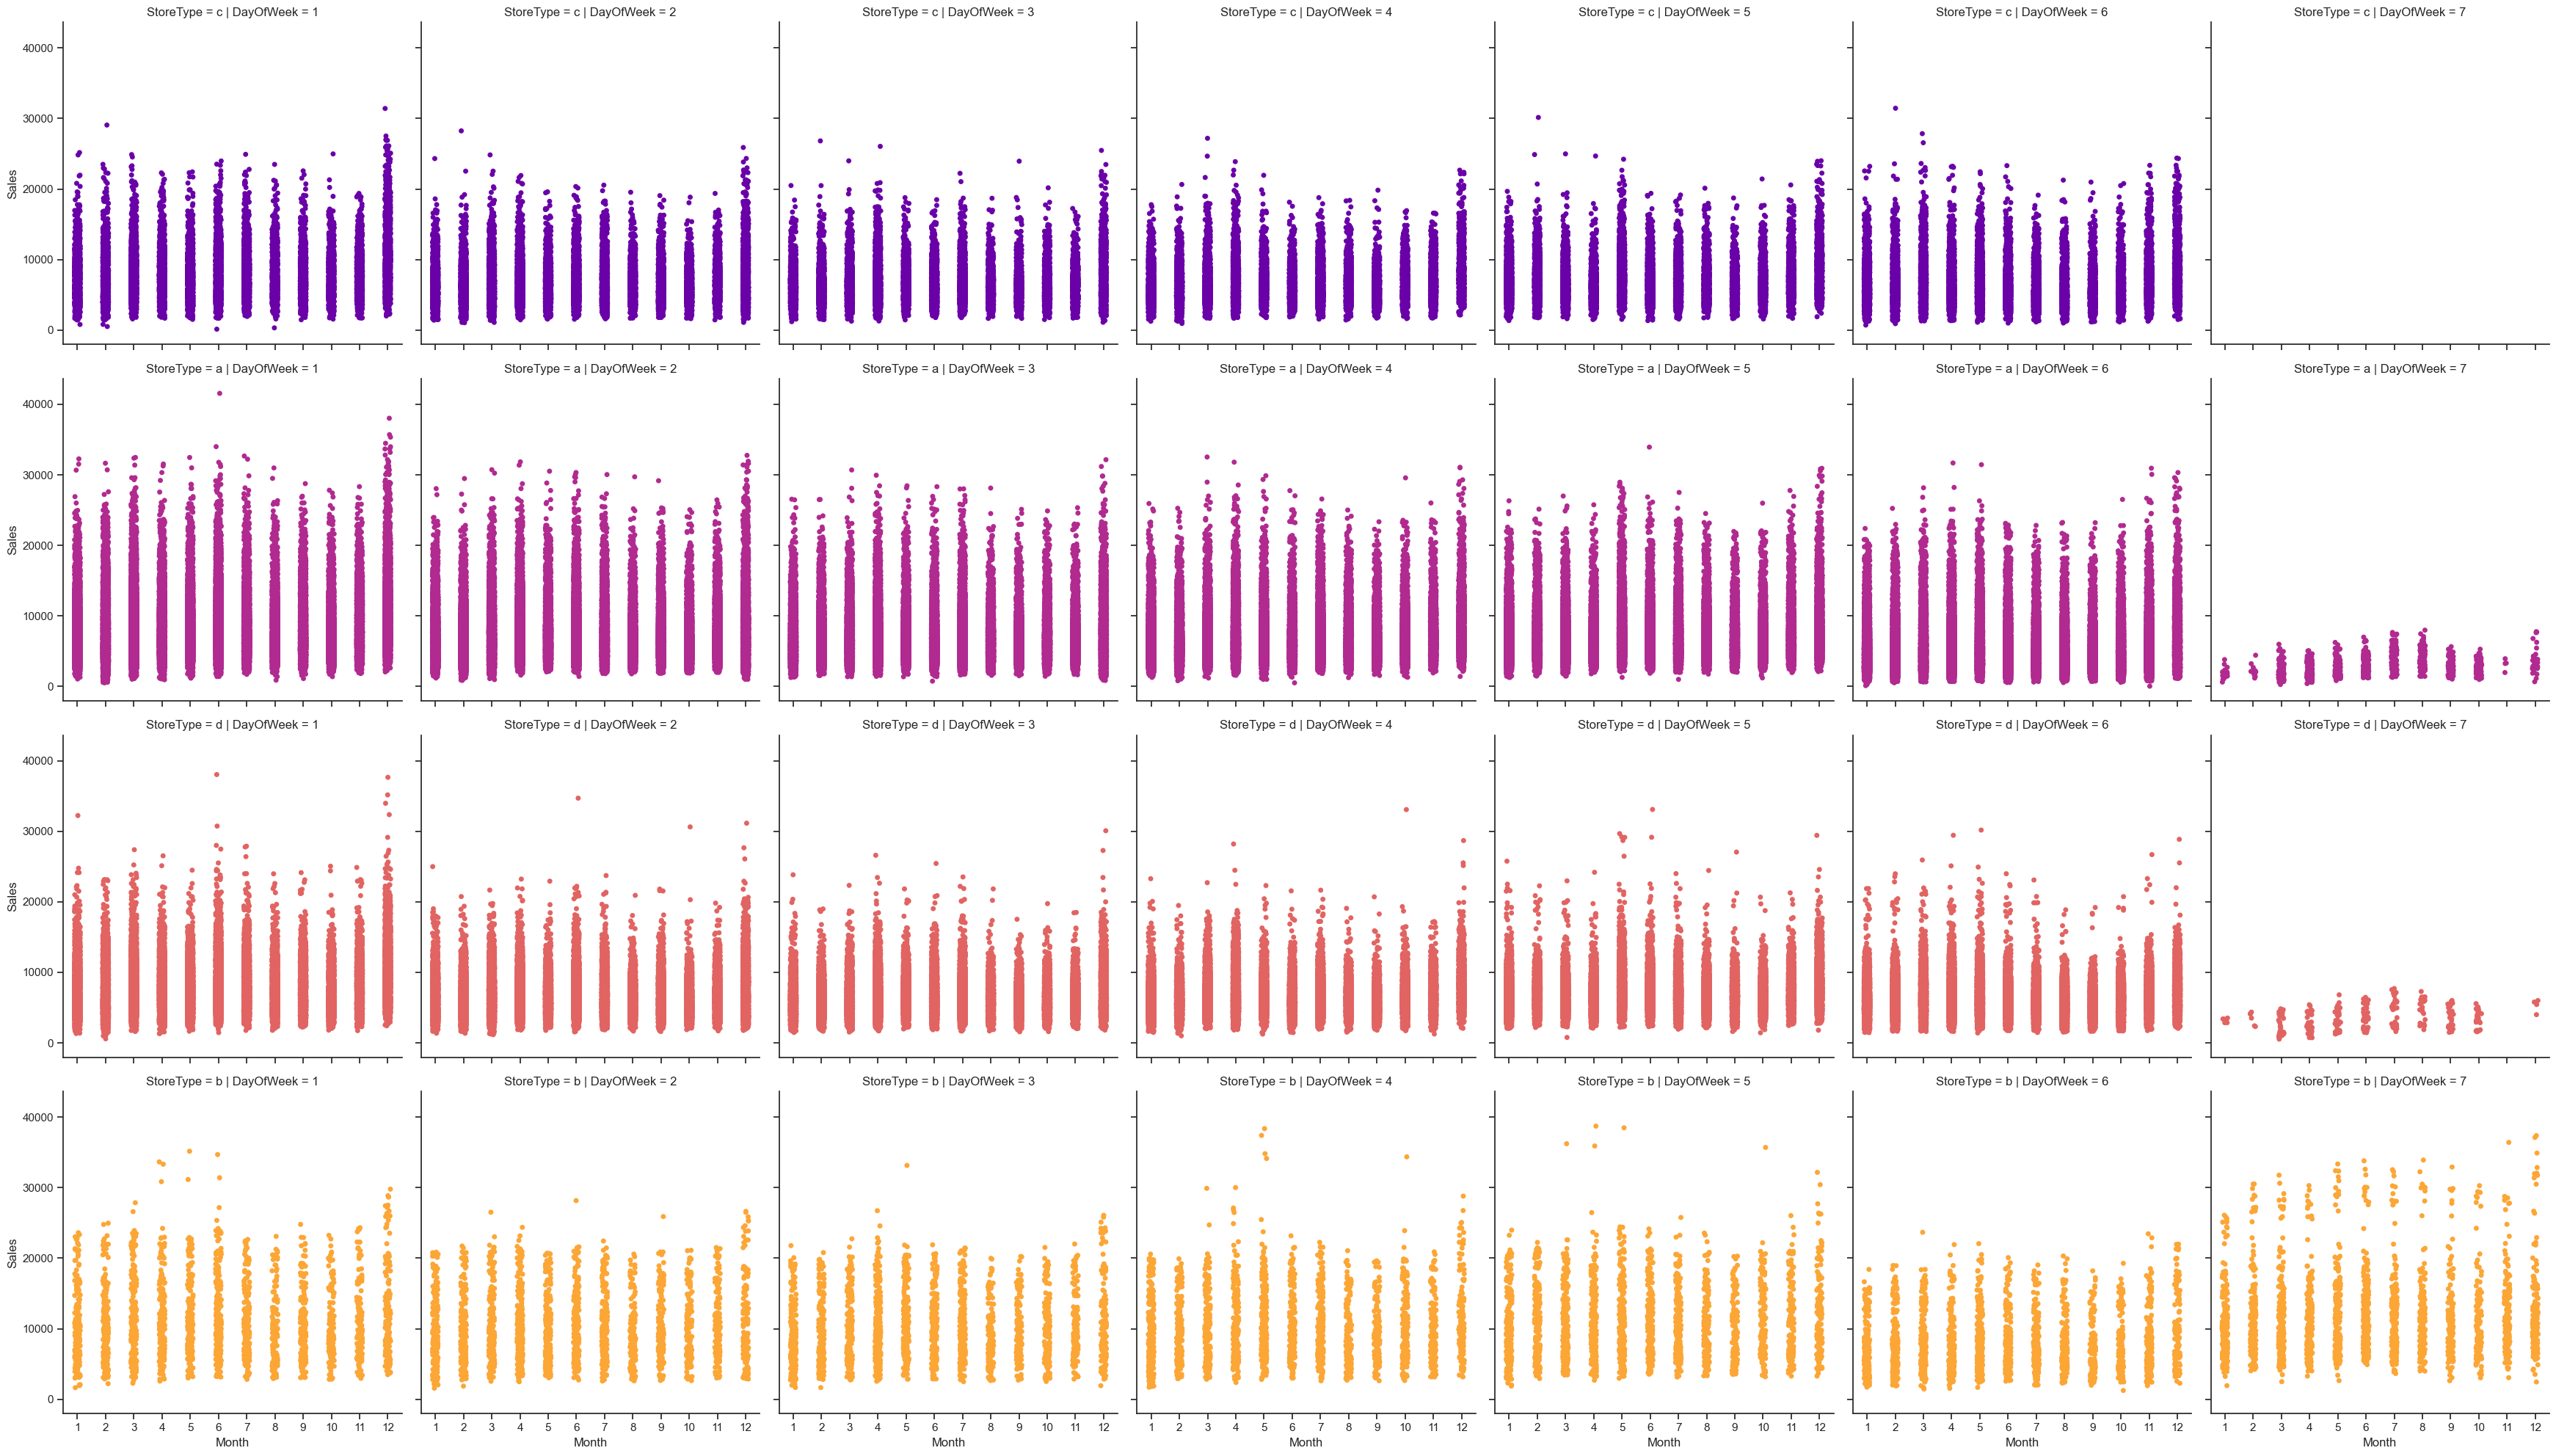

In [40]:
# customers
sns.catplot(data = train_store, x = 'Month', y = "Sales", 
               col = 'DayOfWeek', # per store type in cols
               palette = 'plasma',
               hue = 'StoreType',
               row = 'StoreType', # per store type in rows
               color = c) 

In [41]:
# stores which are opened on Sundays
train_store[(train_store.Open == 1) & (train_store.DayOfWeek == 7)]['Store'].unique()

array([  85,  122,  209,  259,  262,  274,  299,  310,  335,  353,  423,
        433,  453,  494,  512,  524,  530,  562,  578,  676,  682,  732,
        733,  769,  863,  867,  877,  931,  948, 1045, 1081, 1097, 1099],
      dtype=int64)

To complete our preliminary data analysis, we can add variables describing the period of time during which competition and promotion were opened:

In [42]:
# competition open time (in months)
train_store['CompetitionOpen'] = 12 * (train_store.Year - train_store.CompetitionOpenSinceYear) + \
        (train_store.Month - train_store.CompetitionOpenSinceMonth)
    
# Promo open time
train_store['PromoOpen'] = 12 * (train_store.Year - train_store.Promo2SinceYear) + \
        (train_store.WeekOfYear - train_store.Promo2SinceWeek) / 4.0

# replace NA's by 0
train_store.fillna(0, inplace = True)

# average PromoOpen time and CompetitionOpen time per store type
train_store.loc[:, ['StoreType', 'Sales', 'Customers', 'PromoOpen', 'CompetitionOpen']].groupby('StoreType').mean()

,Sales,Customers,PromoOpen,CompetitionOpen
StoreType,,,,
a,6925.697986,795.422370,12918.492198,7115.514452
b,10233.380141,2022.211825,17199.328069,11364.495244
c,6933.126425,815.538073,12158.636107,6745.418694
d,6822.300064,606.353935,10421.916846,9028.526526


### Correlational Analysis

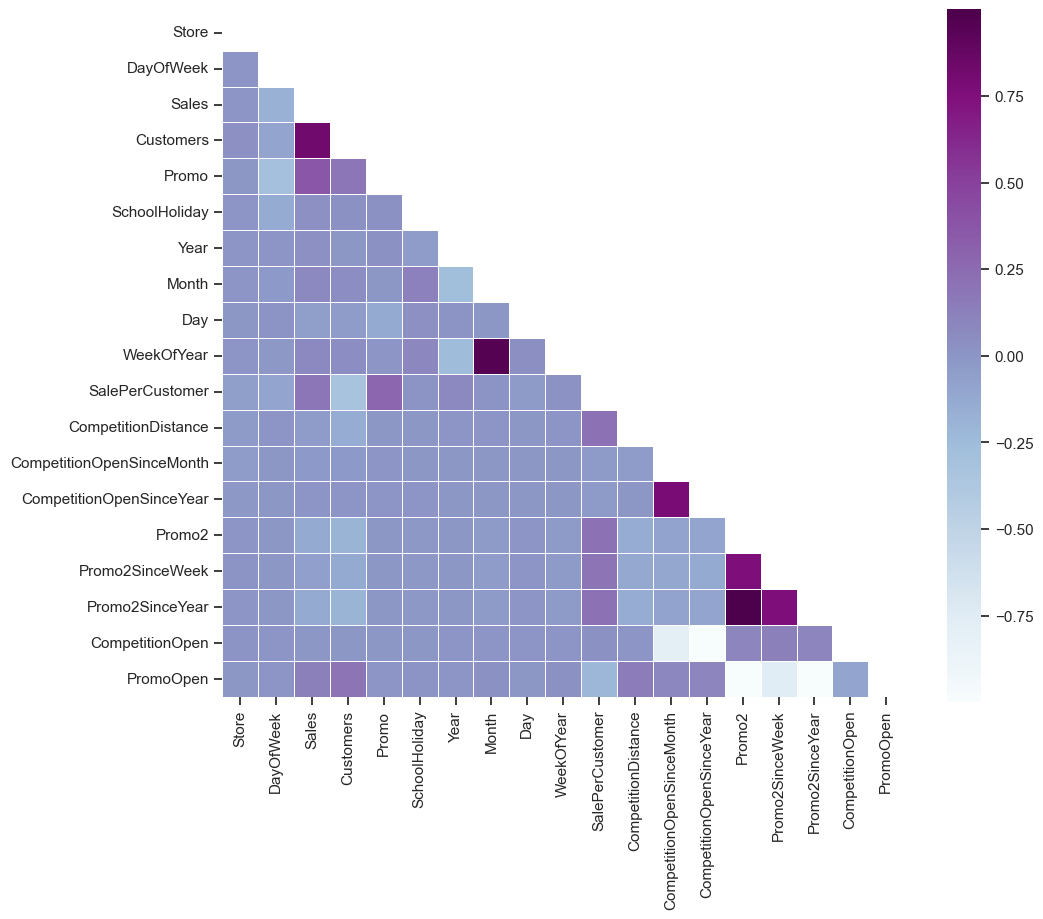

In [43]:
# Compute the correlation matrix 
# exclude 'Open' variable
corr_all = train_store.drop('Open', axis = 1).corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr_all, dtype = np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize = (11, 9))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_all, mask = mask,
            square = True, linewidths = .5, ax = ax, cmap = "BuPu")      
plt.show()

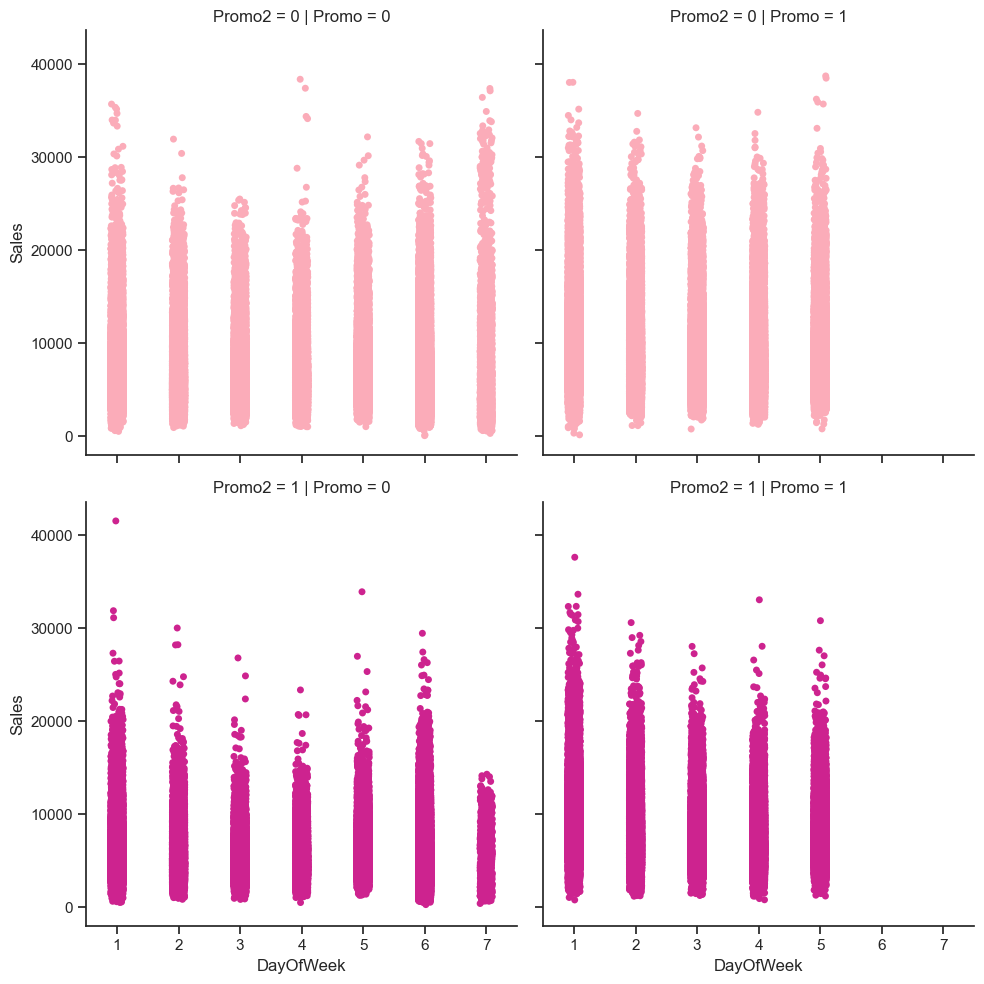

In [45]:
# sale per customer trends
sns.catplot(data = train_store, x = 'DayOfWeek', y = "Sales", 
               col = 'Promo', 
               row = 'Promo2',
               hue = 'Promo2',
               palette = 'RdPu') 

---

## Conclusion of EDA

<br>
## Time-Series Analysis per Store Type

### Seasonality

<AxesSubplot:xlabel='Date'>

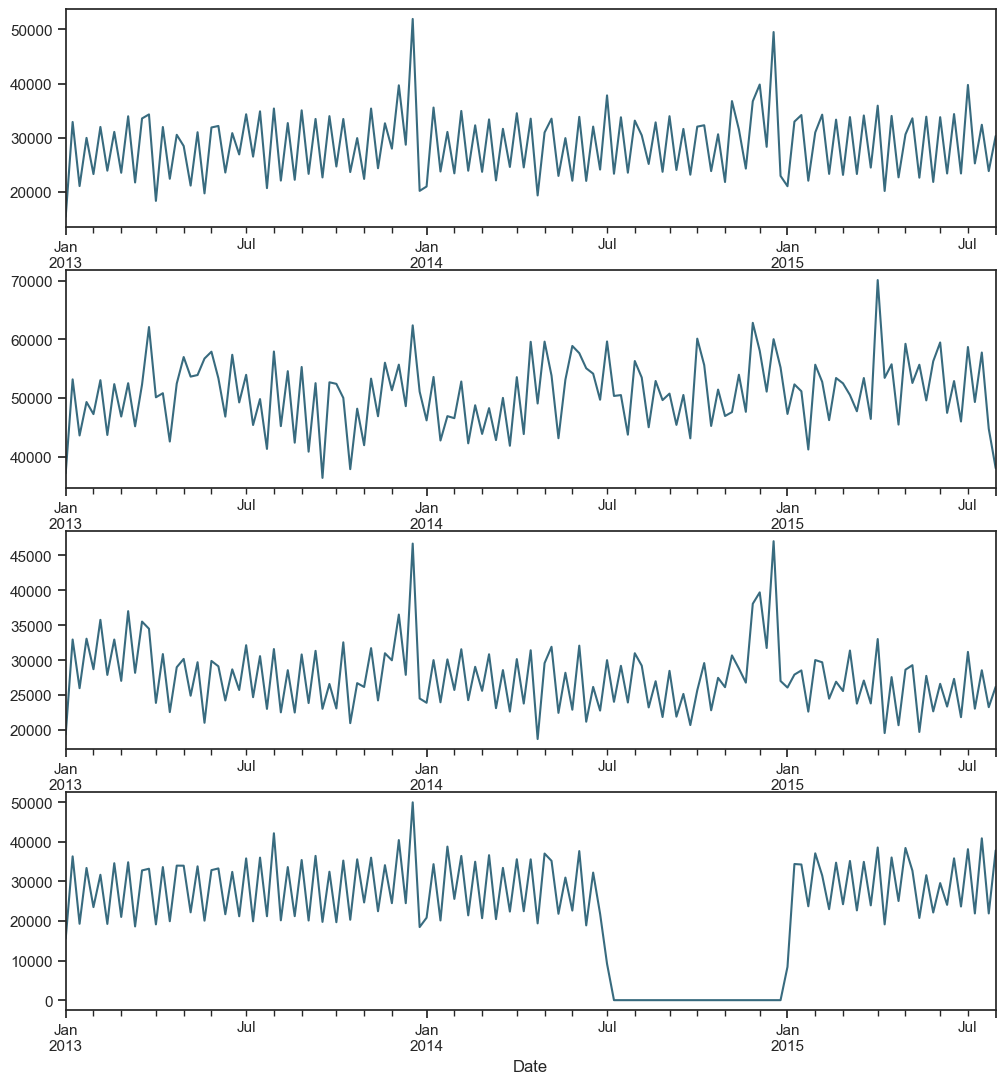

In [46]:
# preparation: input should be float type
train['Sales'] = train['Sales'] * 1.0

# store types
sales_a = train[train.Store == 2]['Sales']
sales_b = train[train.Store == 85]['Sales'].sort_index(ascending = True) # solve the reverse order
sales_c = train[train.Store == 1]['Sales']
sales_d = train[train.Store == 13]['Sales']

f, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize = (12, 13))

# store types
sales_a.resample('W').sum().plot(color = c, ax = ax1)
sales_b.resample('W').sum().plot(color = c, ax = ax2)
sales_c.resample('W').sum().plot(color = c, ax = ax3)
sales_d.resample('W').sum().plot(color = c, ax = ax4)

### Yearly trend

The next thing to check the presence of a trend in series.

<AxesSubplot:xlabel='Date'>

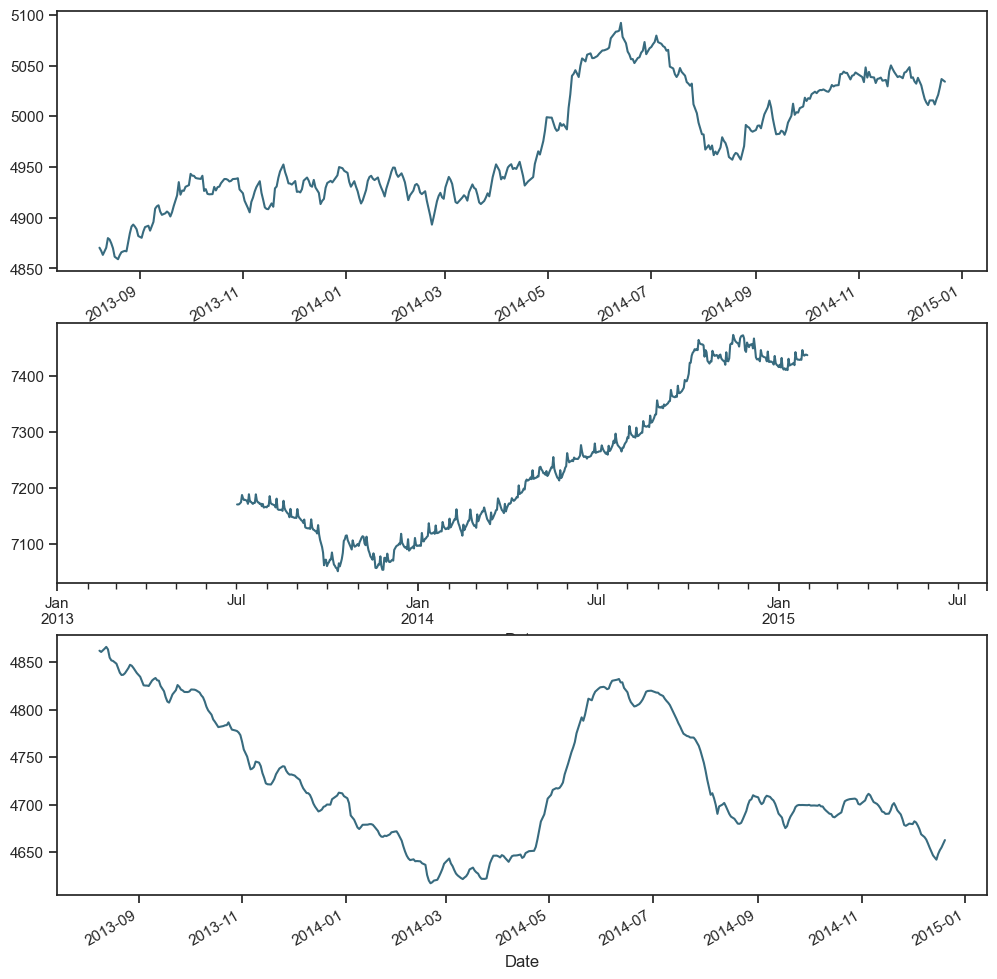

In [56]:
f, (ax1, ax2, ax3) = plt.subplots(3, figsize = (12, 13))

# monthly
decomposition_a = seasonal_decompose(sales_a, model = 'additive', period=365)
decomposition_a.trend.plot(color = c, ax = ax1)

decomposition_b = seasonal_decompose(sales_b, model = 'additive', period=365)
decomposition_b.trend.plot(color = c, ax = ax2)

decomposition_c = seasonal_decompose(sales_c, model = 'additive', period=365)
decomposition_c.trend.plot(color = c, ax = ax3)



### Autocorrelaion

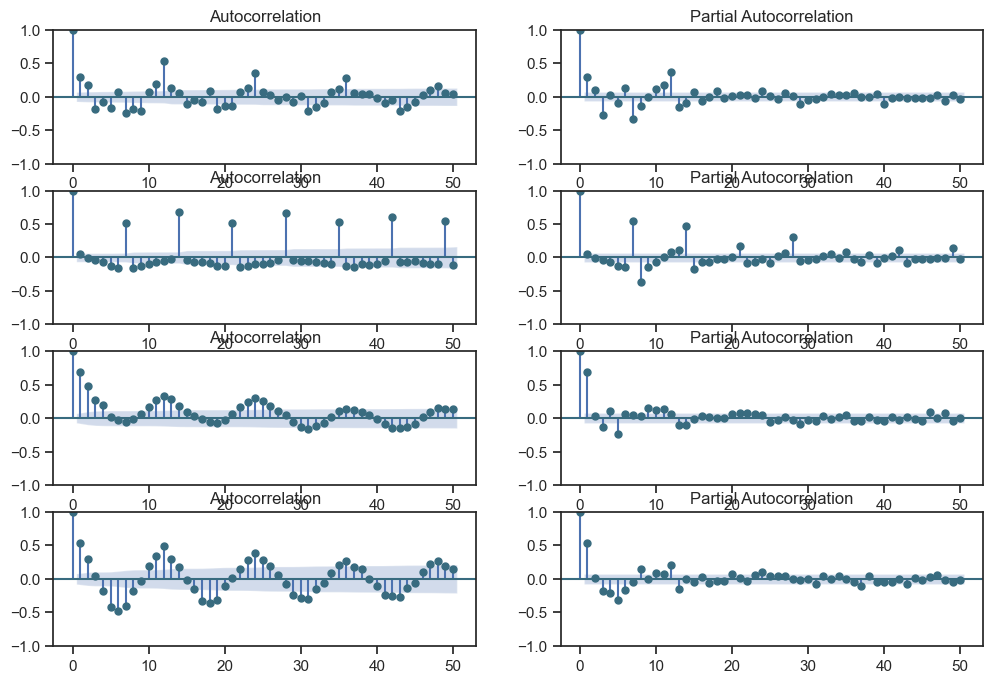

In [57]:
# figure for subplots
plt.figure(figsize = (12, 8))

# acf and pacf for A
plt.subplot(421); plot_acf(sales_a, lags = 50, ax = plt.gca(), color = c)
plt.subplot(422); plot_pacf(sales_a, lags = 50, ax = plt.gca(), color = c)

# acf and pacf for B
plt.subplot(423); plot_acf(sales_b, lags = 50, ax = plt.gca(), color = c)
plt.subplot(424); plot_pacf(sales_b, lags = 50, ax = plt.gca(), color = c)

# acf and pacf for C
plt.subplot(425); plot_acf(sales_c, lags = 50, ax = plt.gca(), color = c)
plt.subplot(426); plot_pacf(sales_c, lags = 50, ax = plt.gca(), color = c)

# acf and pacf for D
plt.subplot(427); plot_acf(sales_d, lags = 50, ax = plt.gca(), color = c)
plt.subplot(428); plot_pacf(sales_d, lags = 50, ax = plt.gca(), color = c)

plt.show()

## Time Series Analysis and Forecasting with Prophet
#### Forecasting for the next 6 weeks for the first store

In [59]:
# importing data
df = pd.read_csv("C:/Users/MANOJ/Downloads/KaiBurr ML/time-series-prophet-master/train.csv",  
                    low_memory = False)

# remove closed stores and those with no sales
df = df[(df["Open"] != 0) & (df['Sales'] != 0)]

# sales for the store number 1 (StoreType C)
sales = df[df.Store == 1].loc[:, ['Date', 'Sales']]

# reverse to the order: from 2013 to 2015
sales = sales.sort_index(ascending = False)

# to datetime64
sales['Date'] = pd.DatetimeIndex(sales['Date'])
sales.dtypes

Date     datetime64[ns]
Sales             int64
dtype: object

In [60]:
# from the prophet documentation every variables should have specific names
sales = sales.rename(columns = {'Date': 'ds',
                                'Sales': 'y'})
sales.head()

,ds,y
1014980,2013-01-02,5530
1013865,2013-01-03,4327
1012750,2013-01-04,4486
1011635,2013-01-05,4997
1009405,2013-01-07,7176


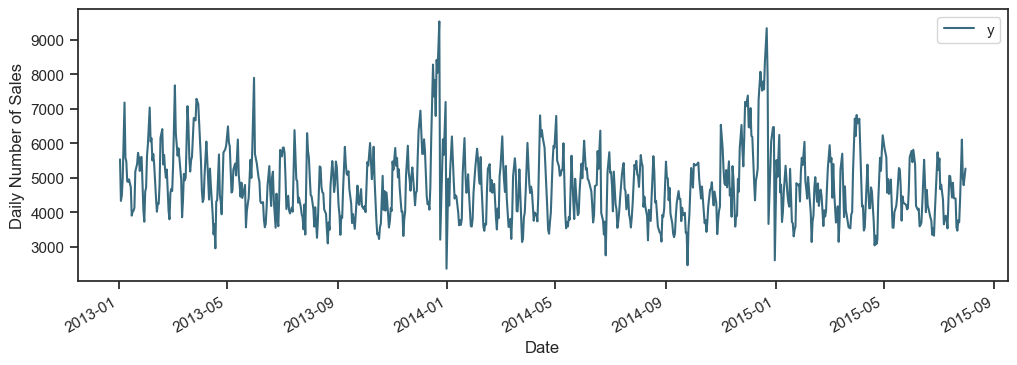

In [61]:
# plot daily sales
ax = sales.set_index('ds').plot(figsize = (12, 4), color = c)
ax.set_ylabel('Daily Number of Sales')
ax.set_xlabel('Date')
plt.show()

### Modeling Holidays

In [62]:
# create holidays dataframe
state_dates = df[(df.StateHoliday == 'a') | (df.StateHoliday == 'b') & (df.StateHoliday == 'c')].loc[:, 'Date'].values
school_dates = df[df.SchoolHoliday == 1].loc[:, 'Date'].values

state = pd.DataFrame({'holiday': 'state_holiday',
                      'ds': pd.to_datetime(state_dates)})
school = pd.DataFrame({'holiday': 'school_holiday',
                      'ds': pd.to_datetime(school_dates)})

holidays = pd.concat((state, school))      
holidays.head()

,holiday,ds
0,state_holiday,2015-06-04
1,state_holiday,2015-06-04
2,state_holiday,2015-06-04
3,state_holiday,2015-06-04
4,state_holiday,2015-06-04


In [63]:
# set the uncertainty interval to 95% (the Prophet default is 80%)
my_model = Prophet(interval_width = 0.95, 
                   holidays = holidays)
my_model.fit(sales)

# dataframe that extends into future 6 weeks 
future_dates = my_model.make_future_dataframe(periods = 6*7)

print("First week to forecast.")
future_dates.tail(7)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


First week to forecast.


,ds
816,2015-09-05
817,2015-09-06
818,2015-09-07
819,2015-09-08
820,2015-09-09
821,2015-09-10
822,2015-09-11


In [64]:
# predictions
forecast = my_model.predict(future_dates)

# preditions for last week
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)

,ds,yhat,yhat_lower,yhat_upper
816,2015-09-05,4092.354773,2526.428585,5827.820182
817,2015-09-06,4087.271369,2433.528085,5687.536931
818,2015-09-07,4162.115745,2619.465117,5752.008258
819,2015-09-08,3664.404103,2200.684741,5309.001174
820,2015-09-09,3551.156461,2038.285662,5187.349395
821,2015-09-10,3462.684465,1878.516613,5073.247930
822,2015-09-11,3717.387024,2107.732549,5369.448466


In [65]:
fc = forecast[['ds', 'yhat']].rename(columns = {'Date': 'ds', 'Forecast': 'yhat'})

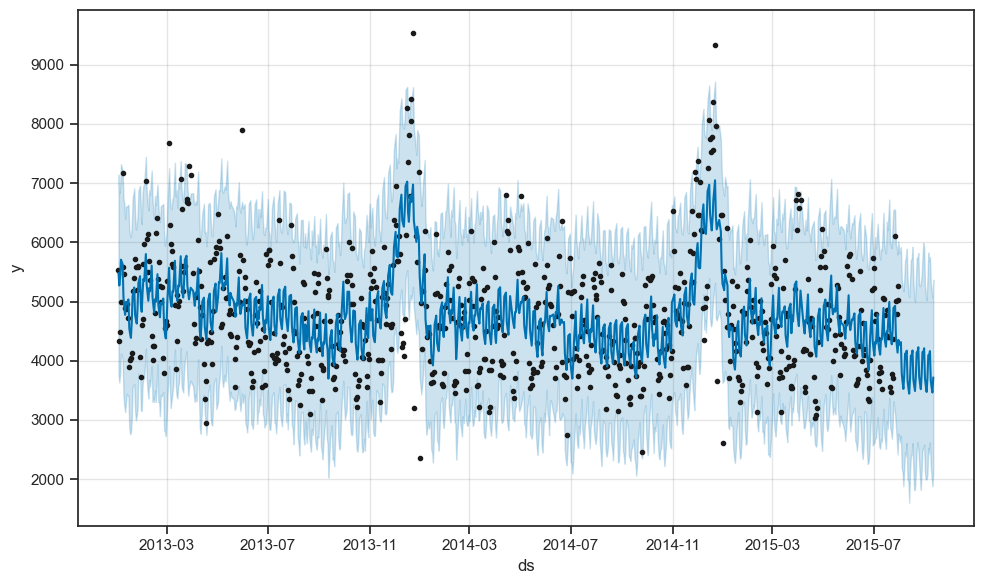

In [66]:
# visualizing predicions
my_model.plot(forecast);

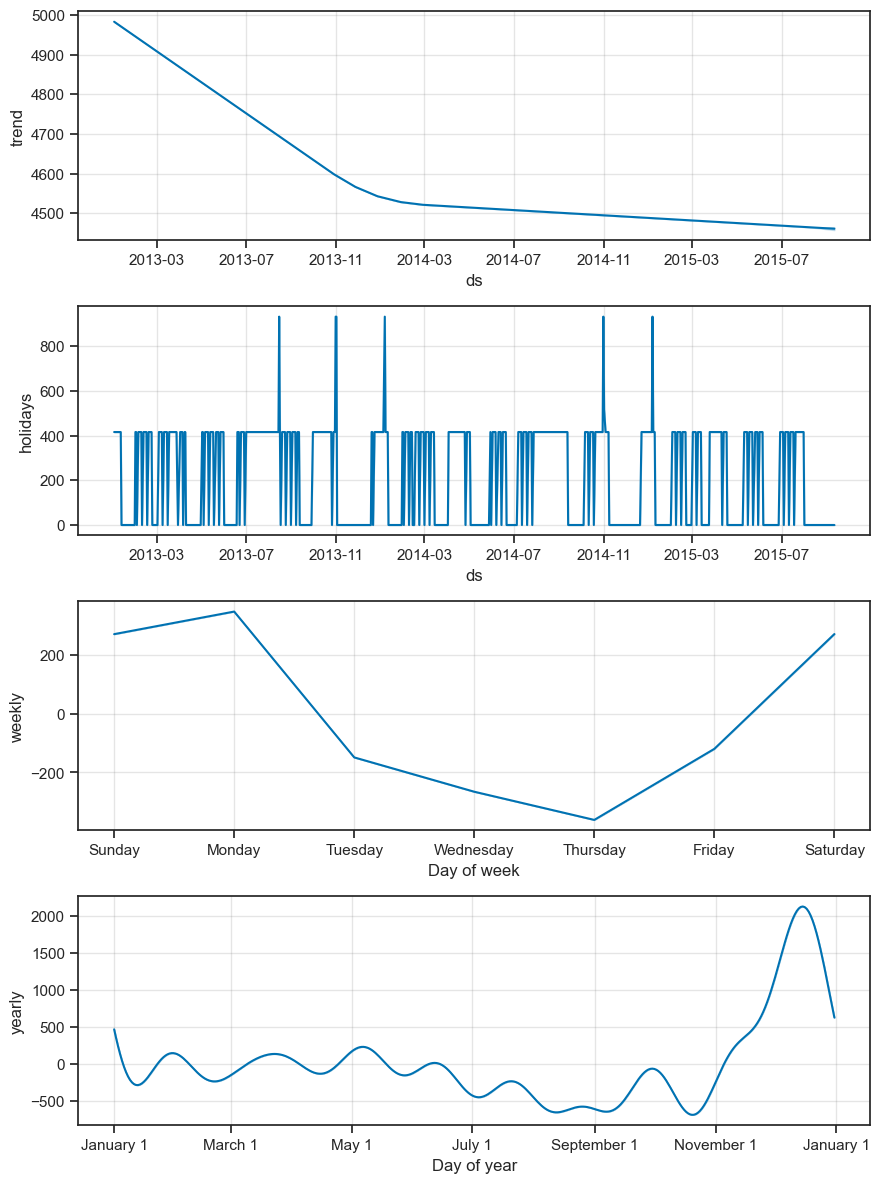

In [67]:
my_model.plot_components(forecast);

### Conclusion of Time Series forecasting

### Quick Run through

In [69]:
# to predict to
test = pd.read_csv("C:/Users/MANOJ/Downloads/KaiBurr ML/time-series-prophet-master/test.csv", 
                    parse_dates = True, low_memory = False, index_col = 'Date')
test.head()

,Id,Store,DayOfWeek,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,
2015-09-17,1,1,4,1.0,1,0,0
2015-09-17,2,3,4,1.0,1,0,0
2015-09-17,3,7,4,1.0,1,0,0
2015-09-17,4,8,4,1.0,1,0,0
2015-09-17,5,9,4,1.0,1,0,0


The Id variable represents a (Store, Date) duple within the test set.

In [70]:
# test: missing values?
test.isnull().sum()

Id                0
Store             0
DayOfWeek         0
Open             11
Promo             0
StateHoliday      0
SchoolHoliday     0
dtype: int64

In [71]:
test[pd.isnull(test.Open)]

,Id,Store,DayOfWeek,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,
2015-09-17,480,622,4,NaN,1,0,0
2015-09-16,1336,622,3,NaN,1,0,0
2015-09-15,2192,622,2,NaN,1,0,0
2015-09-14,3048,622,1,NaN,1,0,0
2015-09-12,4760,622,6,NaN,0,0,0
2015-09-11,5616,622,5,NaN,0,0,0
2015-09-10,6472,622,4,NaN,0,0,0
2015-09-09,7328,622,3,NaN,0,0,0
2015-09-08,8184,622,2,NaN,0,0,0


We see that these stores should be normally opened. Let's assume that they are then.

In [72]:
# replace NA's in Open variable by 1 
test.fillna(1, inplace = True)

### Data Encoding

XGBoost doesn't support anything else than numbers. So prior to modeling we need to encode certain factor variables into numerical plus extract dates as we did before for the train set.

In [73]:
# data extraction
test['Year'] = test.index.year
test['Month'] = test.index.month
test['Day'] = test.index.day
test['WeekOfYear'] = test.index.weekofyear

# to numerical
mappings = {'0':0, 'a':1, 'b':2, 'c':3, 'd':4}
test.StateHoliday.replace(mappings, inplace = True)

train_store.Assortment.replace(mappings, inplace = True)
train_store.StoreType.replace(mappings, inplace = True)
train_store.StateHoliday.replace(mappings, inplace = True)
train_store.drop('PromoInterval', axis = 1, inplace = True)

store.StoreType.replace(mappings, inplace = True)
store.Assortment.replace(mappings, inplace = True)
store.drop('PromoInterval', axis = 1, inplace = True)

Returning back to the `train_store` data:

In [74]:
# take a look on the train and store again
train_store.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,...,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,CompetitionOpen,PromoOpen
0,1,5,5263,555,1,1,0,1,2015,7,...,3,1,1270.0,9.0,2008.0,0,0.0,0.0,82.0,24187.75
1,1,4,5020,546,1,1,0,1,2015,7,...,3,1,1270.0,9.0,2008.0,0,0.0,0.0,82.0,24187.75
2,1,3,4782,523,1,1,0,1,2015,7,...,3,1,1270.0,9.0,2008.0,0,0.0,0.0,82.0,24187.75
3,1,2,5011,560,1,1,0,1,2015,7,...,3,1,1270.0,9.0,2008.0,0,0.0,0.0,82.0,24187.75
4,1,1,6102,612,1,1,0,1,2015,7,...,3,1,1270.0,9.0,2008.0,0,0.0,0.0,82.0,24187.75


Let's merge `test` and `store` data too:

In [75]:
print("Joining test set with an additional store information.")
test_store = pd.merge(test, store, how = 'inner', on = 'Store')

test_store['CompetitionOpen'] = 12 * (test_store.Year - test_store.CompetitionOpenSinceYear) + (test_store.Month - test_store.CompetitionOpenSinceMonth)
test_store['PromoOpen'] = 12 * (test_store.Year - test_store.Promo2SinceYear) + (test_store.WeekOfYear - test_store.Promo2SinceWeek) / 4.0

print("In total: ", test_store.shape)
test_store.head()

Joining test set with an additional store information.
In total:  (41088, 21)


,Id,Store,DayOfWeek,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,...,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,CompetitionOpen,PromoOpen
0,1,1,4,1.0,1,0,0,2015,9,17,...,3,1,1270.0,9.0,2008.0,0,0.0,0.0,84.0,24189.50
1,857,1,3,1.0,1,0,0,2015,9,16,...,3,1,1270.0,9.0,2008.0,0,0.0,0.0,84.0,24189.50
2,1713,1,2,1.0,1,0,0,2015,9,15,...,3,1,1270.0,9.0,2008.0,0,0.0,0.0,84.0,24189.50
3,2569,1,1,1.0,1,0,0,2015,9,14,...,3,1,1270.0,9.0,2008.0,0,0.0,0.0,84.0,24189.50
4,3425,1,7,0.0,0,0,0,2015,9,13,...,3,1,1270.0,9.0,2008.0,0,0.0,0.0,84.0,24189.25


### Model Training

#### Approach

1. Split train data to train and test set to evaluate the model.
2. Set `eta` to a relatively high value (e.g. 0.05 ~ 0.1), num_round to 300 ~ 500
3. Use grid search to find the best combination of additional parameters.
4. Lower `eta` until we reach the optimum.
5. Use the validation set as watchlist to retrain the model with the best parameters. 

In [76]:
# split into training and evaluation sets
# excluding Sales and Id columns
predictors = [x for x in train_store.columns if x not in ['Customers', 'Sales', 'SalePerCustomer']]
y = np.log(train_store.Sales) # log transformation of Sales
X = train_store

# split the data into train/test set
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.3, # 30% for the evaluation set
                                                    random_state = 42)

In [77]:
# predictors
X.columns

Index(['Store', 'DayOfWeek', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'Year', 'Month', 'Day', 'WeekOfYear',
       'SalePerCustomer', 'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'CompetitionOpen', 'PromoOpen'],
      dtype='object')

In [78]:
# evaluation metric: rmspe
# Root Mean Square Percentage Error
# code chunk shared at Kaggle

def rmspe(y, yhat):
    return np.sqrt(np.mean((yhat / y-1) ** 2))

def rmspe_xg(yhat, y):
    y = np.expm1(y.get_label())
    yhat = np.expm1(yhat)
    return "rmspe", rmspe(y, yhat)

#### Tuning Parameters

-  `eta`: Step size used in updating weights. Lower value means slower training but better convergence. 
- `num_round`: Total number of iterations.
- `subsample`: The ratio of training data used in each iteration; combat overfitting. Should be configured in the range of 30% to 80% of the training dataset, and compared to a value of 100% for no sampling.
- `colsample_bytree`: The ratio of features used in each iteration, default 1.
- `max_depth`: The maximum depth of each tree. If we do not limit max depth, gradient boosting would eventually overfit.
- `early_stopping_rounds`: If there's no increase in validation score for a given number of iterations, the algorithm will stop early, also combats overfitting.

In [79]:
# base parameters
params = {
    'booster': 'gbtree', 
    'objective': 'reg:linear', # regression task
    'subsample': 0.8, # 80% of data to grow trees and prevent overfitting
    'colsample_bytree': 0.85, # 85% of features used
    'eta': 0.1, 
    'max_depth': 10, 
    'seed': 42} # for reproducible results

In [80]:
# XGB with xgboost library
dtrain = xgb.DMatrix(X_train[predictors], y_train)
dtest = xgb.DMatrix(X_test[predictors], y_test)

watchlist = [(dtrain, 'train'), (dtest, 'test')]

xgb_model = xgb.train(params, dtrain, 300, evals = watchlist,
                      early_stopping_rounds = 50, feval = rmspe_xg, verbose_eval = True)

[23:40:02] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	train-rmse:7.44338	train-rmspe:0.99953	test-rmse:7.44308	test-rmspe:0.99953
[1]	train-rmse:6.70083	train-rmspe:0.99882	test-rmse:6.70055	test-rmspe:0.99882
[2]	train-rmse:6.03258	train-rmspe:0.99755	test-rmse:6.03232	test-rmspe:0.99755
[3]	train-rmse:5.43132	train-rmspe:0.99541	test-rmse:5.43106	test-rmspe:0.99541
[4]	train-rmse:4.89025	train-rmspe:0.99202	test-rmse:4.88998	test-rmspe:0.99202
[5]	train-rmse:4.40351	train-rmspe:0.98695	test-rmse:4.40324	test-rmspe:0.98695
[6]	train-rmse:3.96567	train-rmspe:0.97974	test-rmse:3.96542	test-rmspe:0.97974
[7]	train-rmse:3.57161	train-rmspe:0.96996	test-rmse:3.57136	test-rmspe:0.96996
[8]	train-rmse:3.21716	train-rmspe:0.95722	test-rmse:3.21689	test-rmspe:0.95721
[9]	train-rmse:2.89858	train-rmspe:0.94119	test-r

[99]	train-rmse:0.14538	train-rmspe:0.18701	test-rmse:0.14879	test-rmspe:0.16257
[100]	train-rmse:0.14494	train-rmspe:0.18650	test-rmse:0.14843	test-rmspe:0.16220
[101]	train-rmse:0.14434	train-rmspe:0.18593	test-rmse:0.14784	test-rmspe:0.16160
[102]	train-rmse:0.14319	train-rmspe:0.18484	test-rmse:0.14674	test-rmspe:0.16044
[103]	train-rmse:0.14289	train-rmspe:0.18454	test-rmse:0.14650	test-rmspe:0.16016
[104]	train-rmse:0.14181	train-rmspe:0.18354	test-rmse:0.14545	test-rmspe:0.15904
[105]	train-rmse:0.14132	train-rmspe:0.18305	test-rmse:0.14498	test-rmspe:0.15857
[106]	train-rmse:0.14015	train-rmspe:0.18231	test-rmse:0.14386	test-rmspe:0.15735
[107]	train-rmse:0.13950	train-rmspe:0.18151	test-rmse:0.14328	test-rmspe:0.15670
[108]	train-rmse:0.13832	train-rmspe:0.18037	test-rmse:0.14217	test-rmspe:0.15555
[109]	train-rmse:0.13745	train-rmspe:0.17960	test-rmse:0.14131	test-rmspe:0.15468
[110]	train-rmse:0.13613	train-rmspe:0.17845	test-rmse:0.14002	test-rmspe:0.15332
[111]	train-rmse:

[199]	train-rmse:0.10202	train-rmspe:0.12884	test-rmse:0.10937	test-rmspe:0.12052
[200]	train-rmse:0.10185	train-rmspe:0.12683	test-rmse:0.10923	test-rmspe:0.12037
[201]	train-rmse:0.10171	train-rmspe:0.12668	test-rmse:0.10915	test-rmspe:0.12028
[202]	train-rmse:0.10155	train-rmspe:0.12647	test-rmse:0.10904	test-rmspe:0.12016
[203]	train-rmse:0.10145	train-rmspe:0.12636	test-rmse:0.10895	test-rmspe:0.12007
[204]	train-rmse:0.10123	train-rmspe:0.12616	test-rmse:0.10877	test-rmspe:0.11990
[205]	train-rmse:0.10103	train-rmspe:0.12545	test-rmse:0.10861	test-rmspe:0.11973
[206]	train-rmse:0.10088	train-rmspe:0.12532	test-rmse:0.10850	test-rmspe:0.11961
[207]	train-rmse:0.10081	train-rmspe:0.12553	test-rmse:0.10845	test-rmspe:0.11956
[208]	train-rmse:0.10060	train-rmspe:0.12532	test-rmse:0.10830	test-rmspe:0.11939
[209]	train-rmse:0.10035	train-rmspe:0.12508	test-rmse:0.10809	test-rmspe:0.11917
[210]	train-rmse:0.10024	train-rmspe:0.12493	test-rmse:0.10800	test-rmspe:0.11905
[211]	train-rmse

[299]	train-rmse:0.08907	train-rmspe:0.10840	test-rmse:0.09976	test-rmspe:0.11063


### Grid Search from sklearn

In [81]:
# XGB with sklearn wrapper
# the same parameters as for xgboost model
params_sk = {'max_depth': 10, 
            'n_estimators': 300, # the same as num_rounds in xgboost
            'objective': 'reg:linear', 
            'subsample': 0.8, 
            'colsample_bytree': 0.85, 
            'learning_rate': 0.1, 
            'seed': 42}     

skrg = XGBRegressor(**params_sk)

skrg.fit(X_train, y_train)

[23:43:36] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.85, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=300, n_jobs=None, num_parallel_tree=None,
             objective='reg:linear', predictor=None, ...)

In [83]:
import scipy.stats as st

params_grid = {  
    'learning_rate': st.uniform(0.01, 0.3),
    'max_depth': list(range(10, 20, 2)),
    'gamma': st.uniform(0, 10),
    'reg_alpha': st.expon(0, 50)}

search_sk = RandomizedSearchCV(skrg, params_grid, cv = 5) # 5 fold cross validation
search_sk.fit(X_train, y_train)

# best parameters
print(search_sk.best_params_); print(search_sk.best_score_)

[12:31:53] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[12:35:40] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[12:39:25] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[12:43:02] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[12:46:57] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscal

[14:20:33] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[14:23:35] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:38] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[14:29:46] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[14:32:54] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscal

In [84]:
# with new parameters
params_new = {
    'booster': 'gbtree', 
    'objective': 'reg:linear', 
    'subsample': 0.8, 
    'colsample_bytree': 0.85, 
    'eta': 0.044338624448041611, 
    'max_depth': 16, 
    'gamma': 0.80198330585415034,
    'reg_alpha': 23.008226565535971,
    'seed': 42} 

model_final = xgb.train(params_new, dtrain, 300, evals = watchlist,
                        early_stopping_rounds = 50, feval = rmspe_xg, verbose_eval = True)

[16:06:04] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	train-rmse:7.90280	train-rmspe:0.99976	test-rmse:7.90248	test-rmspe:0.99976
[1]	train-rmse:7.55325	train-rmspe:0.99959	test-rmse:7.55293	test-rmspe:0.99959
[2]	train-rmse:7.21922	train-rmspe:0.99936	test-rmse:7.21888	test-rmspe:0.99936
[3]	train-rmse:6.90003	train-rmspe:0.99906	test-rmse:6.89969	test-rmspe:0.99906
[4]	train-rmse:6.59502	train-rmspe:0.99866	test-rmse:6.59466	test-rmspe:0.99867
[5]	train-rmse:6.30358	train-rmspe:0.99816	test-rmse:6.30321	test-rmspe:0.99816
[6]	train-rmse:6.02517	train-rmspe:0.99751	test-rmse:6.02480	test-rmspe:0.99751
[7]	train-rmse:5.75908	train-rmspe:0.99670	test-rmse:5.75870	test-rmspe:0.99670
[8]	train-rmse:5.50481	train-rmspe:0.99570	test-rmse:5.50442	test-rmspe:0.99570
[9]	train-rmse:5.26187	train-rmspe:0.99447	test-r

[99]	train-rmse:0.24415	train-rmspe:0.27211	test-rmse:0.24376	test-rmspe:0.23231
[100]	train-rmse:0.24047	train-rmspe:0.27038	test-rmse:0.24011	test-rmspe:0.23003
[101]	train-rmse:0.23847	train-rmspe:0.27004	test-rmse:0.23811	test-rmspe:0.22927
[102]	train-rmse:0.23472	train-rmspe:0.26803	test-rmse:0.23438	test-rmspe:0.22671
[103]	train-rmse:0.23284	train-rmspe:0.26745	test-rmse:0.23251	test-rmspe:0.22598
[104]	train-rmse:0.23097	train-rmspe:0.26713	test-rmse:0.23066	test-rmspe:0.22525
[105]	train-rmse:0.22897	train-rmspe:0.26655	test-rmse:0.22868	test-rmspe:0.22433
[106]	train-rmse:0.22756	train-rmspe:0.26654	test-rmse:0.22727	test-rmspe:0.22395
[107]	train-rmse:0.22574	train-rmspe:0.26591	test-rmse:0.22545	test-rmspe:0.22309
[108]	train-rmse:0.22386	train-rmspe:0.26523	test-rmse:0.22358	test-rmspe:0.22218
[109]	train-rmse:0.22136	train-rmspe:0.26401	test-rmse:0.22108	test-rmspe:0.22048
[110]	train-rmse:0.21911	train-rmspe:0.26312	test-rmse:0.21886	test-rmspe:0.21911
[111]	train-rmse:

[199]	train-rmse:0.15105	train-rmspe:0.22676	test-rmse:0.15124	test-rmspe:0.16561
[200]	train-rmse:0.15088	train-rmspe:0.22665	test-rmse:0.15107	test-rmspe:0.16545
[201]	train-rmse:0.15078	train-rmspe:0.22655	test-rmse:0.15097	test-rmspe:0.16537
[202]	train-rmse:0.14995	train-rmspe:0.22626	test-rmse:0.15014	test-rmspe:0.16451
[203]	train-rmse:0.14948	train-rmspe:0.22605	test-rmse:0.14968	test-rmspe:0.16404
[204]	train-rmse:0.14919	train-rmspe:0.22591	test-rmse:0.14938	test-rmspe:0.16374
[205]	train-rmse:0.14904	train-rmspe:0.22578	test-rmse:0.14924	test-rmspe:0.16361
[206]	train-rmse:0.14871	train-rmspe:0.22551	test-rmse:0.14891	test-rmspe:0.16327
[207]	train-rmse:0.14853	train-rmspe:0.22549	test-rmse:0.14873	test-rmspe:0.16310
[208]	train-rmse:0.14836	train-rmspe:0.22540	test-rmse:0.14857	test-rmspe:0.16295
[209]	train-rmse:0.14828	train-rmspe:0.22534	test-rmse:0.14850	test-rmspe:0.16289
[210]	train-rmse:0.14798	train-rmspe:0.22512	test-rmse:0.14819	test-rmspe:0.16257
[211]	train-rmse

[299]	train-rmse:0.13301	train-rmspe:0.21370	test-rmse:0.13328	test-rmspe:0.14695


In [85]:
yhat = model_final.predict(xgb.DMatrix(X_test[predictors]))
error = rmspe(X_test.Sales.values, np.exp(yhat))

print('First validation yelds RMSPE: {:.6f}'.format(error))

First validation yelds RMSPE: 0.146907


### Model understanding

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

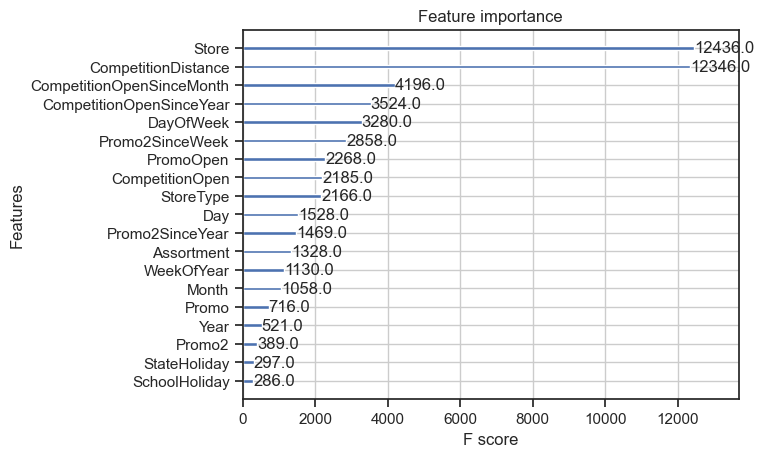

In [86]:
xgb.plot_importance(model_final)

### Prediction to unseen data

In [87]:
# predictions to unseen data
unseen = xgb.DMatrix(test_store[predictors])
test_p = model_final.predict(unseen)

forecasts = pd.DataFrame({'Id': test['Id'], 
                          'Sales': np.exp(test_p)})
# forecasts
forecasts.head()

,Id,Sales
Date,,
2015-09-17,1,4400.959473
2015-09-17,2,4679.979004
2015-09-17,3,5071.210938
2015-09-17,4,5603.327148
2015-09-17,5,5247.499512


---

## Final 

In [90]:
# first
# 0.66419
test_base = xgb_model.predict(unseen)

forecasts_base = pd.DataFrame({'Id': test['Id'], 
                          'Sales': np.exp(test_base)})
forecasts_base.to_csv("xgboost_2_submission.csv", index = False)

In [91]:
# final
# 0.60553
forecasts.to_csv("xgboost_submission.csv", index = False) 